In [375]:
library(data.table)
library(ggplot2)
library(dplyr)
library(viridis)
library(qqman)
library(qvalue)
library(topGO)
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0


Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required p

In [ ]:
#check out angsd results
#hwe <- fread("~/ClownfishGWAS/data/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/appc_angsd.hwe.gz")
#setnames(hwe, 9, "p")
#nrow(hwe)

In [ ]:
#plot(hwe$hweFreq, hwe$Freq) #no super obvious het problems

__make a sites file to filter out linked loci with pcangsd__

In [ ]:
#how do maf and calls across ind look- also make sites files for angsd and filter sites for pcangsd
sites <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/appc_angsd_probs.hwe.gz")
#head(sites)
unlinked <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/appc_unlinked_for_angsd.txt")
setnames(unlinked, 1:2, c("Chromo", "Position"))
unlinked[, filter := 1] #when ngsld has kept the site, mark with 1 so pcangsd knows to keep it
test_filter_sites <- left_join(sites, unlinked) #join with full sites dt and mark linked  sites with 0
#head(test_filter_sites)
#nrow(test_filter_sites)==nrow(sites) #check that this is true
test_filter_sites[is.na(filter), filter := 0]
#write out for pcangsd
#fwrite(test_filter_sites[,.(filter)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/ngsld/filter_linked_sites_pcangsd.txt", col.names = F)

__make positions file for angsd to restrict to unlinked sites__

In [ ]:
nrow(maf[, .N, by="chromo"])
pyam <- unique(maf[chromo %like% "PYAM"], by="chromo")[, chromo] #add the PYAM sites together
names <- maf[chromo %!in% pyam, .N, by="chromo"][, "chromo"] #get a list of chromosome labels
names_with_pyam <- rbind(names, matrix(nrow=1, ncol=1, "PYAM"), use.names=F)
#fwrite(names_with_pyam, "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/ngsld/chromosomes.txt", col.names =F)

__plot the pcangsd results, color by phenotypes in the association__

In [23]:
pca <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/output.pcangsd.cov")

In [ ]:
dim(pca)

In [24]:
#get eigenvalues
ev <-eigen(pca)
ev_dt <- data.table(ev$vectors[,1:10])
setnames(ev_dt, c("pc1", "pc2", "pc3", "pc4", "pc5", "pc6", "pc7", "pc8", "pc9", "pc10"))

In [25]:
#variance explained?
ev$values/sum(ev$values)

[1] 0.210885556 0.006227285 0.006188027 0.006178431 0.006170281 0.006156210
  [7] 0.006136525 0.006120749 0.006100143 0.006092071 0.006088621 0.006085733
 [13] 0.006067177 0.006057354 0.006051042 0.006046759 0.006038278 0.006036200
 [19] 0.006034436 0.006009574 0.006009074 0.006007800 0.006006994 0.006002412
 [25] 0.006001062 0.006000503 0.005995837 0.005993658 0.005988982 0.005979582
 [31] 0.005962752 0.005934171 0.005932039 0.005931601 0.005923389 0.005920369
 [37] 0.005913529 0.005902046 0.005898321 0.005888043 0.005866332 0.005854031
 [43] 0.005841799 0.005834674 0.005832308 0.005827376 0.005826391 0.005801093
 [49] 0.005795495 0.005788146 0.005763565 0.005744137 0.005724283 0.005721111
 [55] 0.005704169 0.005668773 0.005603402 0.005575923 0.005520626 0.005490496
 [61] 0.005292954 0.005273817 0.005250345 0.005215067 0.005207732 0.005183352
 [67] 0.005156018 0.005146994 0.005142300 0.005134883 0.005125624 0.005117904
 [73] 0.005111409 0.005105178 0.005090742 0.005085281 0.005079494 0.005052880
 [79] 0.005043324 0.005032129 0.005018289 0.005002540 0.004980669 0.004961479
 [85] 0.004938959 0.004929439 0.004901744 0.004888660 0.004886747 0.004882833
 [91] 0.004878677 0.004875816 0.004870976 0.004838882 0.004830715 0.004824812
 [97] 0.004818846 0.004810495 0.004801210 0.004795966 0.004789556 0.004758996
[103] 0.004750876 0.004725813 0.004705078 0.004697940 0.004696173 0.004690623
[109] 0.004680488 0.004670783 0.004648239 0.004636661 0.004622637 0.004613630
[115] 0.004605753 0.004600986 0.004590230 0.004569191 0.004561809 0.004558685
[121] 0.004543619 0.004537014 0.004534334 0.004526937 0.004522427 0.004512769
[127] 0.004509655 0.004507771 0.004502826 0.004494850 0.004489577 0.004486402
[133] 0.004483308 0.004480072 0.004471963 0.004471485 0.004463674 0.004461240
[139] 0.004448132 0.004444300 0.004442020 0.004412802 0.004404241 0.004398023
[145] 0.004355561 0.004335499 0.004316104 0.004255849 0.004245531 0.004213902
[151] 0.004176323 0.004091696 0.003954023

__join together the metadata with other covariates and phenotypes with the pcs- be sure to check that the samples are ordered the same as bamlist__

In [26]:
bamlist <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/bamlist.list.txt")
meta <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), Group :=-999][Group=="High", Group:=1][Group=="Low", Group:=0][, .(sample=gen_id, ucrit=Ucrit, sl=SL, dam, sire, case=Group, capture=Capture)]
sorted_meta <- left_join(bamlist, meta, by="sample")
pca_phenos <- cbind(sorted_meta , ev_dt)[, sequencing_lib := ifelse(capture %in% c("Pop01","Pop02","Pop03", "Pop04", "Pop05", "Pop06", "Pop07","Pop08"), 1, 2)]
#write out the pcs to use as covariates
#fwrite(pca_phenos[, "capture"], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/capture.cov", col.names = F)

Warning message in `[.data.table`(fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/Sample_Meta.txt")[is.na(Group), :
“Coerced double RHS to character to match the type of the target column (column 10 named 'Group'). If the target column's type character is correct, it's best for efficiency to avoid the coercion and create the RHS as type character. To achieve that consider R's type postfix: typeof(0L) vs typeof(0), and typeof(NA) vs typeof(NA_integer_) vs typeof(NA_real_). You can wrap the RHS with as.character() to avoid this warning, but that will still perform the coercion. If the target column's type is not correct, it's best to revisit where the DT was created and fix the column type there; e.g., by using colClasses= in fread(). Otherwise, you can change the column type now by plonking a new column (of the desired type) over the top of it; e.g. DT[, `Group`:=as.double(`Group`)]. If the RHS of := has nrow(DT) elements then the assignment is called a c

In [47]:
pca_unlinked <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/pc1-3_unlinked.cov")

In [50]:
#pca_unlinked$sample <- bamlist$sample
pca_pheno_unlinked <- cbind(pca_unlinked, pca_phenos[,1:3])

In [51]:
head(pca_pheno_unlinked)

V1,V2,V3,sample,ucrit,sl
-0.092607712,0.0174850921,-0.0244912829,Pop01_APPC1611,8.13,4.40
-0.114829109,-0.0122763883,-0.0045606441,Pop01_APPC1917,1.20,4.35
0.003392844,-0.0002162177,0.0002983512,Pop01_APPC1921,7.33,4.28
-0.034442932,-0.9970604955,0.0148471171,Pop01_APPC2029,8.82,4.25
0.022761767,-0.0009952023,0.0006811659,Pop01_APPC2030,7.32,4.54
0.079684748,0.0003954962,0.0004661896,Pop01_APPC2101,5.07,3.94


In [ ]:
filter <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/PCAngsd_Filter2.txt")

In [ ]:
pca_phenos$pcangsd_filter <- filter[,1]

In [ ]:
pca_phenos[, pcangsd_filter :=ifelse(sample %in% pca_phenos[pc2 < -0.75, sample],0, pcangsd_filter)]

In [48]:
head(pca_phenos)

sample,ucrit,sl,dam,sire,case,capture,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,sequencing_lib
Pop01_APPC1611,8.13,4.40,D125,S144,1,Pop01,-0.092670635,-0.0217683252,-0.0823144410,-0.1177519963,0.4325507351,0.815169472,0.304143123,6.085239e-02,-0.0479891950,-0.0103735832,1
Pop01_APPC1917,1.20,4.35,D85,S173,0,Pop01,-0.114995555,-0.0049404088,-0.0084712579,-0.0073748237,0.0151975141,-0.018869047,-0.036858803,-1.936825e-02,0.0220150535,-0.0045099847,1
Pop01_APPC1921,7.33,4.28,D85,S173,1,Pop01,0.003367341,0.0003246282,0.0004035543,0.0004142743,-0.0008168261,0.001172834,0.002222074,-2.361056e-05,-0.0006646217,0.0004675780,1
Pop01_APPC2029,8.82,4.25,D70,S98,1,Pop01,0.022773539,0.0007730465,0.0013156391,0.0010744393,-0.0022055729,0.002976713,0.005192988,2.428480e-03,-0.0018301433,0.0007796293,1
Pop01_APPC2030,7.32,4.54,D70,S98,1,Pop01,0.079804091,0.0005373194,0.0009161695,0.0008095938,-0.0014722499,0.001812070,0.003008333,3.132228e-03,-0.0029753554,0.0003094787,1
Pop01_APPC2101,5.07,3.94,D269,S94,1,Pop01,-0.126313695,-0.0035292362,-0.0047799108,-0.0066165296,0.0102512081,-0.012732940,-0.026813842,-8.009059e-03,0.0123313716,-0.0502423383,1


In [ ]:
nrow(pca_phenos[pcangsd_filter==0])
#pca_phenos$capture <- gsub(pca_phenos$capture, "Pop", "", fixed = T)

In [ ]:
fwrite(pca_phenos[,.(pcangsd_filter)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/PCAngsd_Filter3.txt", col.names = FALSE )

In [ ]:
fwrite(pca_phenos[,.(pc1, pc2, pc3)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/genotypes/angsd/pc1-3_unlinked.cov", col.names = FALSE )

In [54]:
#what pcs/covariates explain the phenotype?
predictors <- as.data.table(summary(glm(data=pca_pheno_unlinked, sl ~ V1+V2+V3))$coeff)
 
predictors$names <- row.names(summary(glm(data=pca_pheno_unlinked, sl ~ V1+V2+V3))$coeff)
setnames(predictors, 4, "pvalue")
predictors[pvalue <0.06][order(pvalue)]

Estimate,Std. Error,t value,pvalue,names
4.2565577,0.01110523,383.293050,2.851757e-217,(Intercept)
-0.2634892,0.13867298,-1.900076,5.943614e-02,V1


In [56]:
predictors <- as.data.table(summary(glm(data=pca_pheno_unlinked, ucrit ~ V1+V2+V3))$coeff)
 
predictors$names <- row.names(summary(glm(data=pca_pheno_unlinked, ucrit ~ V1+V2+V3))$coeff)
setnames(predictors, 4, "pvalue")
predictors[pvalue <0.08][order(pvalue)]

Estimate,Std. Error,t value,pvalue,names
4.077585,0.2397162,17.01005,2.820919e-37,(Intercept)


In [ ]:
summary(aov(data=pca_phenos, pc2~dam))
summary(aov(data=pca_phenos, pc2~sire))
summary(aov(data=pca_phenos, pc2~sl))

In [ ]:
ggplot()+
    geom_boxplot(data=pca_phenos, aes(x=dam, y=pc1))+
    theme(axis.text.x=element_text(angle=90,hjust=1))

In [ ]:
ggplot()+
    geom_boxplot(data=pca_phenos, aes(x=dam, y=ucrit))+
    theme(axis.text.x=element_text(angle=90,hjust=1))

In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=as.factor(case)))

In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos[], aes(x=pc1, y=pc2, col=sl)) +
#    scale_color_viridis(color.palette=magma)

In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=ucrit)) +
#    scale_color_viridis(option="magma")

In [ ]:
#ggplot()+
#    geom_point(data=pca_phenos, aes(x=pc1, y=pc2, col=sequencing_lib)) +
#    scale_color_viridis(option="magma")

In [ ]:
ggplot(data=pca_phenos, aes(x=pc1, y=pc2, col=dam, label=sample))+
    geom_point() #+
    #geom_text(nudge_x = 0.02)

### evaluate model and plot GWAS results for each phenotype

In [370]:
lrt_ucrit <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/ucrit_assoc5_maf0.05_noMaxdepth_minQ30_minCount16.lrt0.gz")
lrt_ucrit[, locus := paste(Chromosome, Position, sep=":")]
setnames(lrt_ucrit, "LRTscore", "LRT")

#filter out loci in hwe and NAN
lrt_filt_ucrit <- lrt_ucrit[LRT>0]
#lrt_filt <- lrt[LRT>0]
#format for manhattan plot
#get pvalues
lrt_filt_ucrit$pvalue<-dchisq(lrt_filt_ucrit$LRT, df=1)
#lrt_filt_ucrit[, Chromosome := gsub(".","", Chromosome, fixed = T)][, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]
#lrt_filt_ucrit[, Chromosome := as.numeric(Chromosome)]
lrt_filt_ucrit$SNP<-paste("r",1:length(lrt_filt_ucrit$Chromosome), sep="")


lrt_filt_ucrit <- lrt_filt_ucrit[order(LRT)][,quantile:=1:nrow(lrt_filt_ucrit)/nrow(lrt_filt_ucrit)] #quantiles for observed lrt
exp_lrt_ucrit <- data.table( exp_lrt = rchisq(nrow(lrt_filt_ucrit), 1))[order(exp_lrt)]
lrt_filt_ucrit$exp_lrt_ucrit <-exp_lrt_ucrit[, exp_lrt]


In [358]:
lrt_sl <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/sl_assoc5_maf0.05_noMaxdepth_unlinkedPC1cov_minQ30_minCount16.lrt0.gz")
lrt_sl[, locus := paste(Chromosome, Position, sep=":")]
#for hybrid assoc 5
#setnames(lrt_sl, "LRTscore", "LRT")
#filter out loci in hwe and NAN
lrt_filt_sl <- lrt_sl[LRT>0]
#lrt_filt <- lrt[LRT>0]
#format for manhattan plot
#get pvalues
lrt_filt_sl$pvalue<-dchisq(lrt_filt_sl$LRT, df=1)
#lrt_filt_sl[, Chromosome := gsub(".","", Chromosome, fixed = T)][, Chromosome := gsub("CM","", Chromosome, fixed = T)][, Chromosome := gsub("PYAM","", Chromosome, fixed = T)]
#lrt_filt_sl[, Chromosome := as.numeric(Chromosome)]
lrt_filt_sl$SNP<-paste("r",1:length(lrt_filt_sl$Chromosome), sep="")


lrt_filt_sl <- lrt_filt_sl[order(LRT)][,quantile:=1:nrow(lrt_filt_sl)/nrow(lrt_filt_sl)] #quantiles for observed lrt
exp_lrt_sl <- data.table( exp_lrt = rchisq(nrow(lrt_filt_sl), 1))[order(exp_lrt)]
lrt_filt_sl$exp_lrt_sl <-exp_lrt_sl[, exp_lrt]


In [261]:
summary(lrt_filt_sl$LRT)


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000001  0.558519  2.259545  3.371162  5.220612 27.188659 

[1] 0.7438263

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000001  0.075038  0.337829  0.751227  0.991546 15.517314 

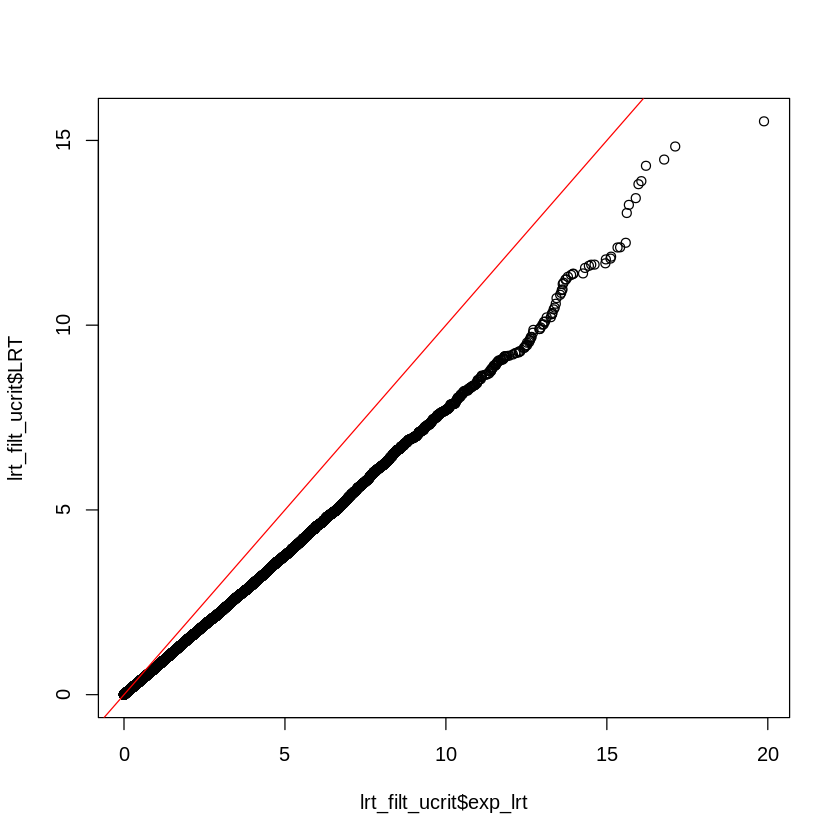

[1] 1.4823

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000001  0.151434  0.672920  1.366583  1.892780 21.312784 

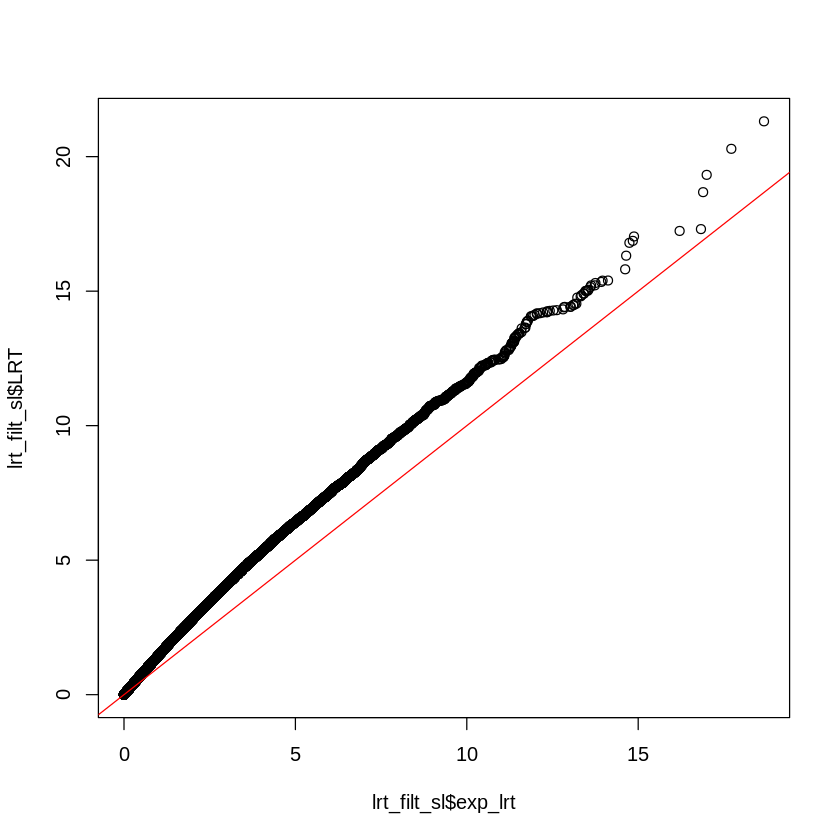

In [368]:
#compare plots and inflation 
qqplot(lrt_filt_ucrit$exp_lrt, lrt_filt_ucrit$LRT)
abline(0, 1, col = "red")
median(lrt_filt_ucrit$LRT) / median(lrt_filt_ucrit$exp_lrt) #GC lambda = ratio at medians
summary(lrt_filt_ucrit$LRT)


qqplot(lrt_filt_sl$exp_lrt, lrt_filt_sl$LRT)
abline(0, 1, col = "red")
median(lrt_filt_sl$LRT) / median(lrt_filt_sl$exp_lrt) #GC lambda = ratio at medians
summary(lrt_filt_sl$LRT)


In [364]:
head(lrt_filt_ucrit)

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP,quantile,exp_lrt_ucrit
1,11203219,T,C,0.299552,159,1e-06,35/35/1,NaN,NaN,NaN,0,1:11203219,398.9421,r1530,7.528193e-06,3.184246e-11
1,27701448,C,A,0.217886,159,1e-06,10/14/0,NaN,NaN,NaN,0,1:27701448,398.9421,r2790,1.505639e-05,1.177899e-10
1,41412714,T,A,0.228360,159,1e-06,11/10/1,NaN,NaN,NaN,0,1:41412714,398.9421,r4303,2.258458e-05,1.361573e-10
1,42839370,C,T,0.252014,159,1e-06,14/17/0,NaN,NaN,NaN,0,1:42839370,398.9421,r4728,3.011277e-05,2.984269e-09
2,38211704,C,G,0.364653,159,1e-06,13/20/2,NaN,NaN,NaN,0,2:38211704,398.9421,r8876,3.764097e-05,3.830128e-09
4,3107432,A,G,0.206735,159,1e-06,39/30/1,NaN,NaN,NaN,0,4:3107432,398.9421,r18814,4.516916e-05,3.885042e-09


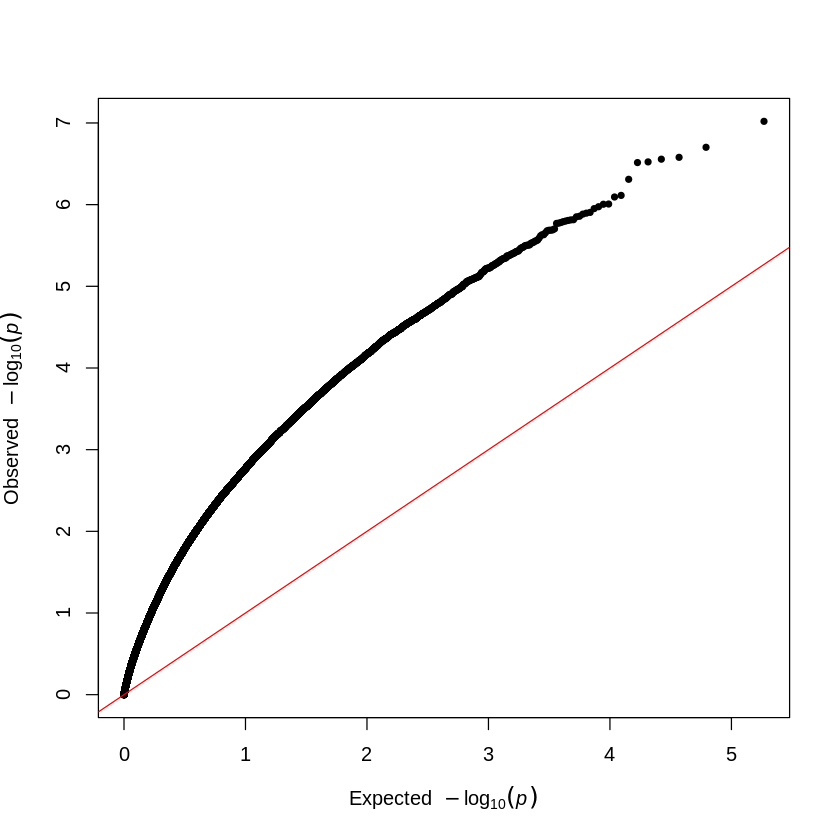

In [263]:
qqman::qq(lrt_filt_sl$pvalue) 

In [371]:
#compare how each phenotype separates from null
lrt_ucrit_null <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/assoc2/cat_permuted_assoc2_ucrit.lrt")
#lrt_ucrit[, locus := paste(Chromosome, Position, sep=":")]

lrt_sl_null <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/permute/assoc2/cat_permuted_assoc2_sl.lrt")
#lrt_sl[, locus := paste(Chromosome, Position, sep=":")]
#filter out loci in hwe and NAN




In [372]:
max(lrt_ucrit_null$LRT)
max(lrt_sl_null$LRT)

[1] 23.34577

[1] 26.2002

In [281]:
max(lrt_filt_ucrit$LRT)
max(lrt_filt_sl$LRT)

[1] 18.12104

[1] 21.31278

__try using the permutations as the expected for the qq plot__

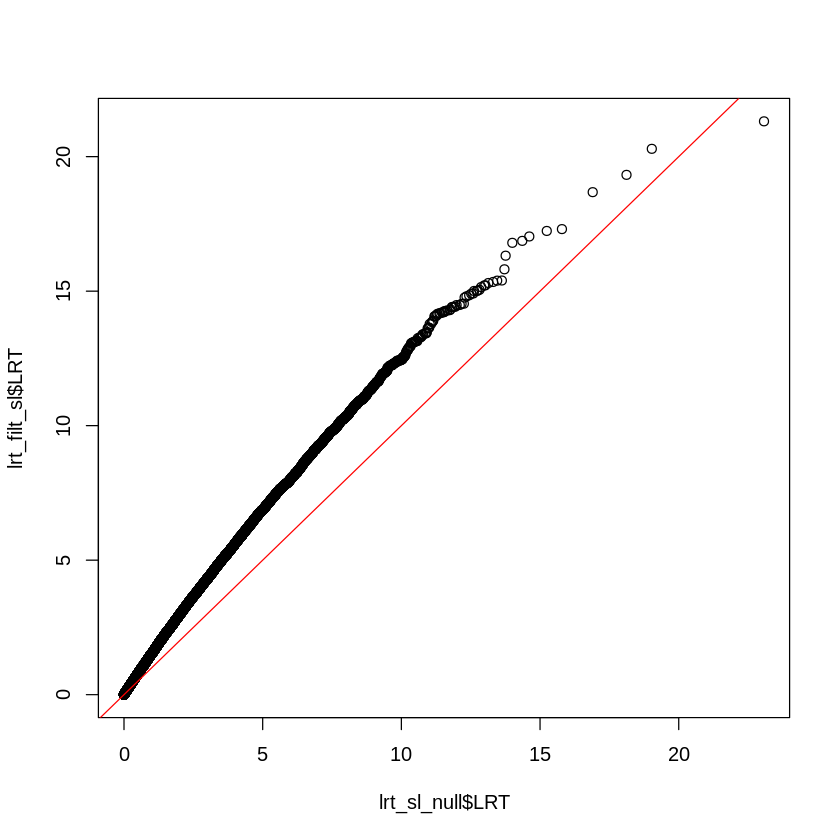

In [282]:
lrt_sl_null <- lrt_sl_null[LRT > 0][order(LRT)][,quantile:=1:nrow(lrt_sl_null[LRT > 0])/nrow(lrt_sl_null[LRT > 0])] #quantiles for observed lrt
qqplot(lrt_sl_null$LRT, lrt_filt_sl$LRT)
abline(0, 1, col = "red")

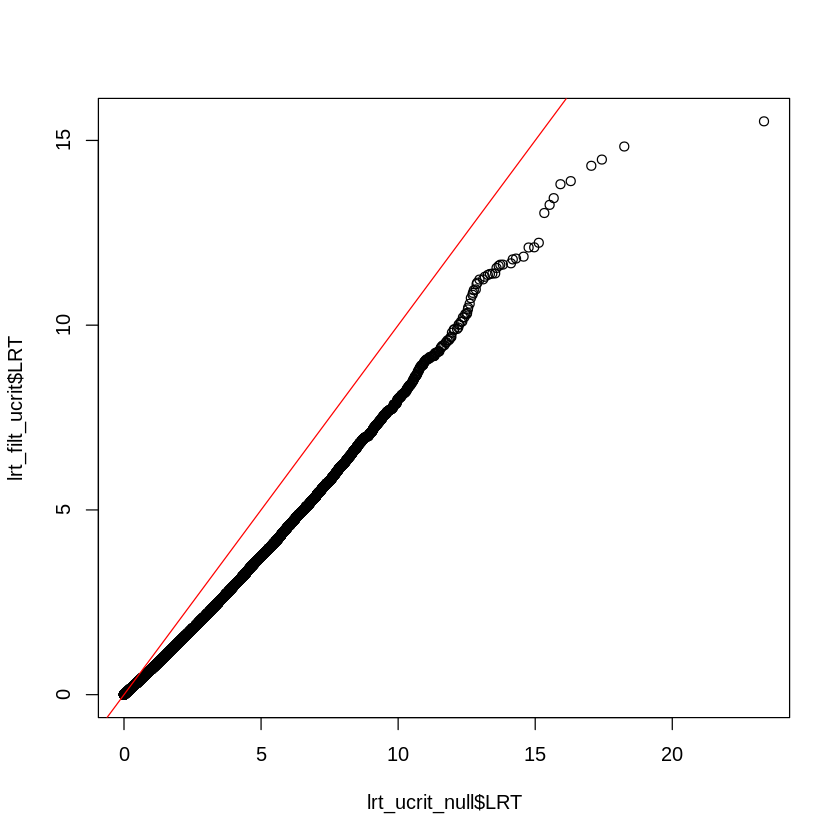

In [369]:
lrt_ucrit_null <- lrt_ucrit_null[LRT > 0][order(LRT)][,quantile:=1:nrow(lrt_ucrit_null[LRT > 0])/nrow(lrt_ucrit_null[LRT > 0])] #quantiles for observed lrt
qqplot(lrt_ucrit_null$LRT, lrt_filt_ucrit$LRT)
abline(0, 1, col = "red")

__Get the top 5% of LRT from the null permutations, find snps above that threshold in true association__

In [300]:
0.001 *nrow(lrt_ucrit_null[LRT >0])

[1] 531.419

In [301]:
ucrit_null_top <- lrt_ucrit_null[LRT >0][order(-LRT)][1:531,]

In [360]:
summary(ucrit_null_top$LRT)
candidates_ucrit <- lrt_filt_ucrit[LRT > min(ucrit_null_top$LRT)]
nrow(candidates_ucrit)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.31   10.72   11.41   11.99   12.64   23.35 

[1] 34

__Also for SL phenotype__

In [297]:
summary(lrt_filt_sl$LRT)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000001  0.151434  0.672920  1.366583  1.892780 21.312784 

In [298]:
summary(lrt_sl_null[LRT>0, LRT])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
 0.000001  0.092041  0.409936  0.899869  1.193869 23.074246 

In [303]:
0.001 *nrow(lrt_sl_null[LRT >0])

[1] 437.177

In [361]:
sl_null_top <- lrt_sl_null[LRT >0][order(-LRT)][1:437,]
summary(sl_null_top$LRT)
candidates_sl <- lrt_filt_sl[LRT > min(sl_null_top$LRT)]
nrow(candidates_sl)
summary(candidates_sl$pvalue)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  9.593  10.094  10.776  11.316  11.966  23.074 

[1] 508

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
2.035e-06 2.610e-04 5.170e-04 5.318e-04 7.869e-04 1.064e-03 

In [305]:

candidates_sl[locus %in% candidates_ucrit$locus]

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP,quantile,exp_lrt_sl,rank,padjBH


In [306]:
min(lrt_filt_ucrit$pvalue)

[1] 1.088639e-05

__Calculate the BH critical threshold__

In [284]:
lrt_filt_ucrit <- lrt_filt_ucrit[order(pvalue)]
lrt_filt_ucrit$rank=1:NROW(lrt_filt_ucrit) #rank snp by order
lrt_filt_ucrit$padjBH=(lrt_filt_ucrit$rank/nrow(lrt_filt_ucrit))*.2 #then calculate the critical by dividing each rank by the total number of snps, and then multiply by fdr
lrt_filt_ucrit_sig=lrt_filt_ucrit[lrt_filt_ucrit$pvalue<lrt_filt_ucrit$padjBH,]
lrt_filt_ucrit_sig

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,LRTem,beta,SE,emIter,locus,pvalue,SNP,quantile,exp_lrt_ucrit,rank,padjBH


In [285]:
lrt_filt_sl <- lrt_filt_sl[order(pvalue)]
lrt_filt_sl$rank=1:NROW(lrt_filt_sl) #rank snp by order
lrt_filt_sl$padjBH=(lrt_filt_sl$rank/nrow(lrt_filt_sl))*.2 #then calculate the critical by dividing each rank by the total number of snps, and then multiply by fdr
lrt_filt_sl_sig=lrt_filt_sl[lrt_filt_sl$pvalue<lrt_filt_sl$padjBH,]
lrt_filt_sl_sig

Chromosome,Position,Major,Minor,Frequency,N,LRT,high_WT/HE/HO,locus,pvalue,SNP,quantile,exp_lrt_sl,rank,padjBH
24,16962690,T,G,0.258409,147,20.29089,10/13/0,24:16962690,3.476556e-06,r104351,0.9999906,16.15693,2,3.775437e-06
10,406013,C,T,0.253512,147,14.06247,11/13/0,10:406013,9.402687e-05,r42819,0.9995375,12.57565,50,9.438593e-05


In [286]:
candidate_sl_bh <- lrt_filt_sl[pvalue < max(lrt_filt_sl_sig$pvalue)]
nrow(candidate_sl_bh[order(Chromosome, Position)] )

[1] 49

In [232]:
gw_sl <- dchisq(min(sl_null_top$LRT), df=1)
gw_sl_null <- dchisq(min(ucrit_null_top$LRT), df=1)
pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/sl_manhattan.pdf")
qqman::manhattan(lrt_filt_sl, chr="Chromosome", bp="Position", p="pvalue", genomewideline = -log10(max(lrt_filt_sl_sig$pvalue)), suggestiveline = F)
dev.off()

png 
  2

In [186]:
gw_ucrit_null <- dchisq(min(ucrit_null_top$LRT), df=1)
pdf("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/ucrit_manhattan.pdf")
qqman::manhattan(lrt_filt_ucrit, chr="Chromosome", bp="Position", p="pvalue", genomewideline = -log10(gw_ucrit_null), suggestiveline = F)
dev.off()

png 
  2

__write out a list of candidate loci for blast__

In [309]:
candidates_sl_blast <- candidates_sl[,.(locus, Chromosome, start=Position-3000, end=Position+3000)]#, range=paste0(start, end, sep="-"))]

In [311]:
candidates_ucrit_blast <- candidates_ucrit[,.(locus, Chromosome, start=Position-3000, end=Position+3000)]#, range=paste0(start, end, sep="-"))]

In [312]:
candidates_sl_blast[, range:=paste(start, end, sep="-")]

In [313]:
candidates_ucrit_blast[, range:=paste(start, end, sep="-")]

In [314]:
fwrite(candidates_sl_blast[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_sl_loci3kbp.bed", sep="\t", col.names = F)
fwrite(candidates_sl_bh[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_sl_loci3kbp.bed", sep="\t", col.names = F)

In [315]:
fwrite(candidates_ucrit_blast[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_ucrit_loci3kbp.bed", sep="\t", col.names = F)

__write out the candidate positions to find closest feature in percula genome__

In [362]:
candidates_sl_bedops <- candidates_sl[,.(locus, Chromosome, start=Position-100, end=Position+100)]#, range=paste0(start, end, sep="-"))]
candidates_ucrit_bedops <- candidates_ucrit[,.(locus, Chromosome, start=Position-100, end=Position+100)]#, range=paste0(start, end, sep="-"))]
fwrite(candidates_sl_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_sl_loci100bp.bed", sep="\t", col.names = F)
fwrite(candidates_ucrit_bedops[,.(Chromosome, start, end)], "/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/candidates_ucrit_loci100bp.bed", sep="\t", col.names = F)

## blast and bedops in candidate_loci.pynb.

__read in blast results from amarel__

In [344]:
blast_ucrit_zebra <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/zebra_ucrit_candidates_results3kb.out")
blast_header <- c("qseqid", "sseqid", "sstart", "send", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "evalue", "bitscore")
setnames(blast_ucrit_zebra, blast_header)
blast_ucrit_zebra[, db :="zebra"]

blast_ucrit_frenatus <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/afrenatus_ucrit_candidates_results3kb.out")
blast_header <- c("qseqid", "sseqid", "sstart", "send", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "evalue", "bitscore")
setnames(blast_ucrit_frenatus, blast_header)
blast_ucrit_frenatus[, db :="frenatus"]

blast_ucrit <- rbind(blast_ucrit_frenatus, blast_ucrit_zebra)

In [340]:
blast_sl_zebra <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/zebra_sl_candidates_results3kb.out")
blast_header <- c("qseqid", "sseqid", "sstart", "send", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "evalue", "bitscore")
setnames(blast_sl_zebra, blast_header)
blast_sl_zebra[, db :="zebra"]

blast_sl_frenatus <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/afrenatus_sl_candidates_results3kb.out")
blast_header <- c("qseqid", "sseqid", "sstart", "send", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "evalue", "bitscore")
setnames(blast_sl_frenatus, blast_header)
blast_sl_frenatus[, db :="frenatus"]

blast_sl <- rbind(blast_sl_frenatus, blast_sl_zebra)

In [349]:
best_blast_sl <- blast_sl[, .SD[which.max(bitscore)], by =c("qseqid", "db")] #sort by best evalue for each locus
best_blast_sl[, `:=`(sstart=ifelse(sstart > send, send, sstart), send=ifelse(sstart > send, sstart, send))]

In [350]:
best_blast_ucrit <- blast_ucrit[, .SD[which.max(bitscore)], by =c("qseqid", "db")] #sort by best evalue for each locus
best_blast_ucrit[, `:=`(sstart=ifelse(sstart > send, send, sstart), send=ifelse(sstart > send, sstart, send))]

__print out the best and then extract those regions from the corresponding gff in candidate_loci.ipynb__

In [355]:
fwrite(best_blast_sl[db=="frenatus",.(sseqid, sstart, send)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/best_blast_sl_3kbp_frenatus.bed", col.names = F, sep="\t")
fwrite(best_blast_sl[db=="zebra",.(sseqid, sstart, send)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/best_blast_sl_3kbp_zebra.bed", col.names = F, sep="\t")

In [356]:
fwrite(best_blast_ucrit[db=="frenatus",.(sseqid, sstart, send)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/best_blast_ucrit_3kbp_frenatus.bed", col.names = F, sep="\t")
fwrite(best_blast_ucrit[db=="zebra",.(sseqid, sstart, send)],"/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/best_blast_ucrit_3kbp_zebra.bed", col.names = F, sep="\t")

__read the extracted gff files back in to narrow down on the best and get the go annotations for enrichment__

In [211]:
blast_sl <- fread("/data/katrinac/APPC_sequencing/DNA/trimmed_reads/mapping/ensembl/genotypes/angsd/results/zebra_sl_candidates_results.out")
best_blast_sl <- blast_sl[, .SD[which.min(evalue)], by ="qseqid"] #sort by best evalue for each locus
best_blast_sl[, `:=`(sstart=ifelse(sstart > send, send, sstart), send=ifelse(sstart > send, sstart, send))]
head(best_blast_sl)
nrow(best_blast_sl)

qseqid,sseqid,sstart,send,pident,length,mismatch,gapopen,qstart,qend,evalue,bitscore
2:5427895-5437894,CHR_ALT_CTG8_1_11,26631634,26631715,86.747,83,10,1,7448,7530,1.39e-13,91.6
2:23958024-23968023,16,20607110,20607141,100.000,32,0,0,835,866,3.92e-04,60.2
3:14330725-14340724,3,56308670,56308830,87.654,162,19,1,5019,5180,1.73e-42,187.0
5:26591316-26601315,16,55120665,55120876,78.605,215,39,4,883,1093,6.34e-27,135.0
6:1316877-1326876,6,55332457,55332555,84.158,101,12,4,7111,7209,1.08e-14,95.3
7:5223068-5233067,16,52608493,52608671,82.123,179,32,0,8236,8414,1.75e-32,154.0


[1] 24

In [ ]:
Proportion of variance in phenotype explained by a given SNP (PVE) = [2*(beta^2)*MAF*(1-MAF)]/[2*(beta^2)*MAF(1-MAF)+((se(beta))^2)*2*N*MAF*(1-MAF)]
where:
N - sample size
se(beta) - standard error of effect size for the genetic variant of interest
beta - effect size for the genetic variant of interest
MAF - minor allele frequency for the genetic variant of interest
it is described in:
Shim, H., Chasman, D.I., Smith, J.D., Mora, S., Ridker, P.M., Nickerson, D.A., Krauss, R.M., and Stephens, M. (2015). A multivariate genome-wide association analysis of 10 LDL subfractions, and their response to statin treatment, in 1868 Caucasians. PLoS One 10, e0120758.
Supplementary Information: S1: Computing proportion of variance in phenotype explained by a given SNP (PVE).